<a href="https://colab.research.google.com/github/wyliewen775/ChatGPT/blob/main/Llama2_QLoRA_4bit_Fine_Tuning_AND_Semantic_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

**Author**: [Martin Liu](https://www.linkedin.com/in/hflhmartin/), Tech Leader @ Lyft's Machine Learning Platform

**About**:
* Demo of fine-tuning [LLAMA2](https://huggingface.co/meta-llama) with QLoRA, then use the model with Semantic Search

* This notebook can [run in Google Colab](https://colab.research.google.com/drive/1WxlPhCS-k2gd3bqQzImaLFYhDLnx4ReT) with a free instance (which has a Tesla T4 16G GPU mem).

# [QLoRA](http://export.arxiv.org/pdf/2305.14314.pdf) 4bit fine-tuning
Fine tune LLM `LLAMA2-13B` with [alpaca dataset](https://github.com/gururise/AlpacaDataCleaned).

Load model:
+ 13b with float32 -> 52G GPU Mem
+ 13b with int8 -> 13G
+ 13b with nf4 (4 bit NormalFloat) -> 6.5G

Train model:
+ With `adamw` optimizer, it requires additonal `3 * float32` (gradient, 2 internal states) per trainable parameter

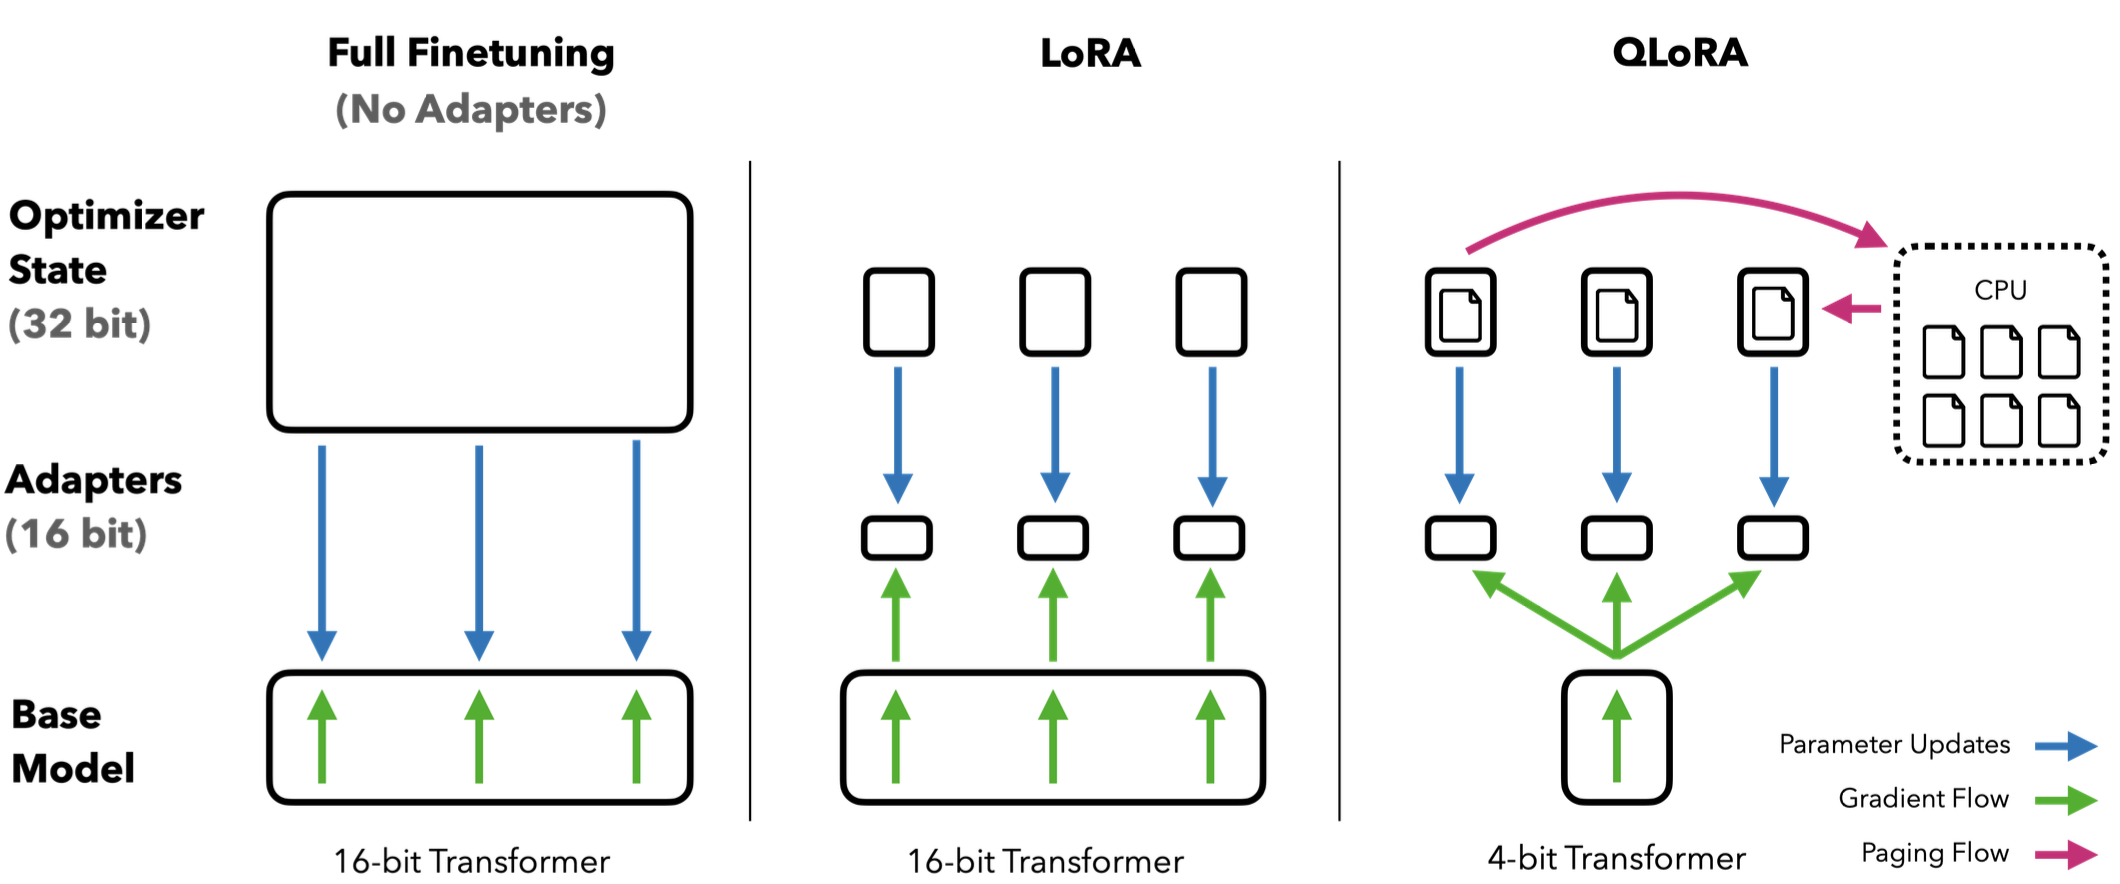


## LoRA

 * **Hypothesis:** `Weights change` of pretrained model during fine tune has a low “intrinsic rank”
   - Inspired by [this paper](https://arxiv.org/abs/2012.13255)
 * **Approach**:
   - For each layer ($W \in R^{d\times{h}}$), froze `W`, add 2 additional layers (A & B) to simulating `ΔW`
   - Choose a rank `r << min(d, h)`, $A \in R^{d\times{r}}$, $B \in R^{r\times{h}}$. We want to make $\Delta W = BA$
   - e.g. let's say `ΔW` is `1000 * 1000` (1M parameters), we may have `A`(1000 * 2) and `B`(2 * 1000) which total 4K parameters.

 * **Advantage**
   - Less gpu mem usage, no inference latency increase
   - Decouple pre-trained model and Lora module, can change Lora modules for different tasks.

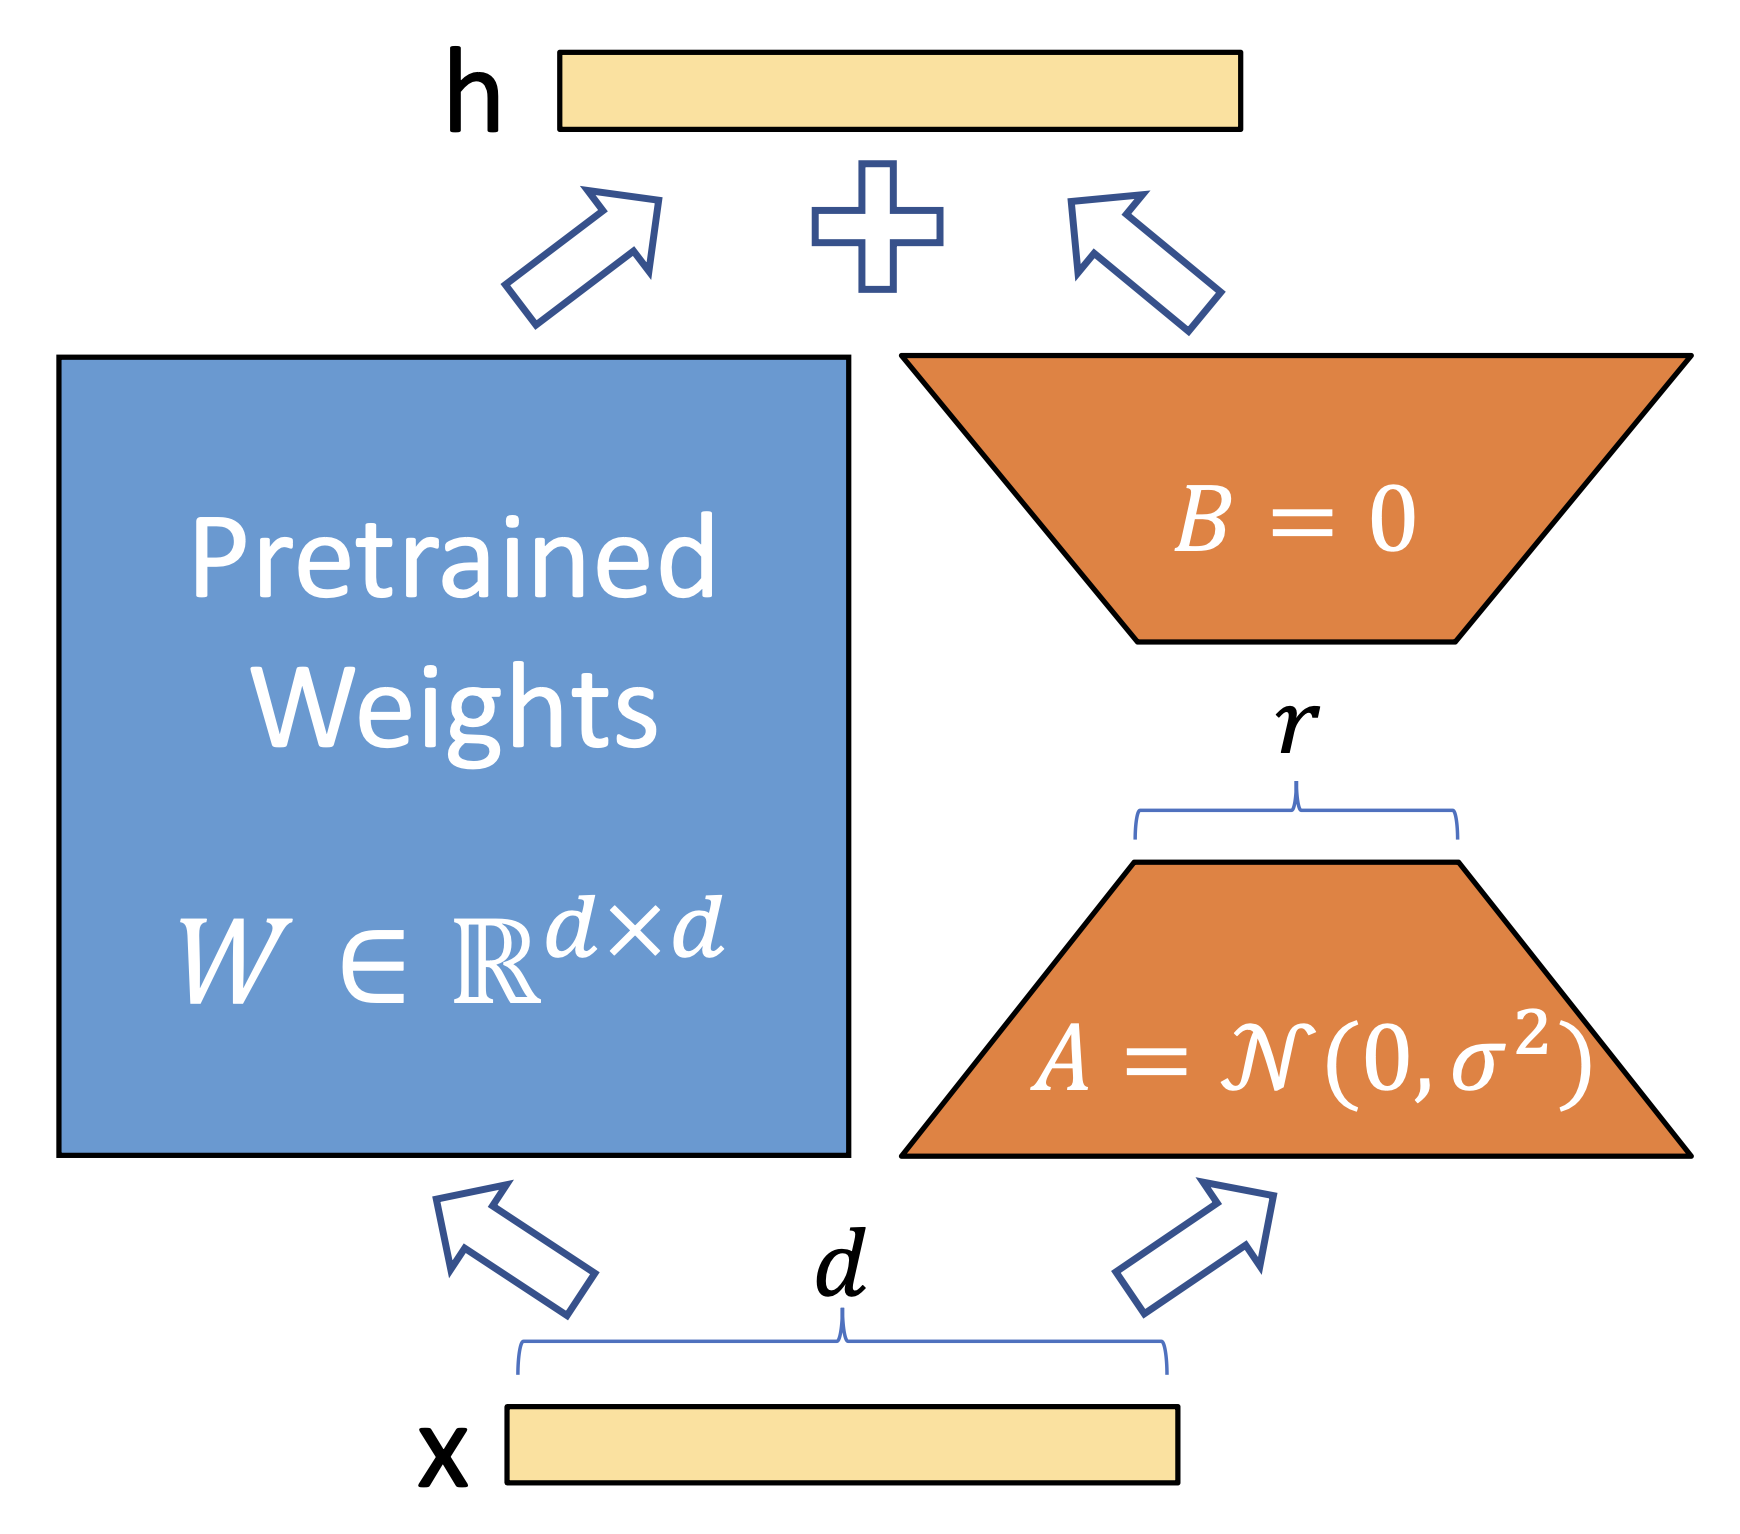

## QLoRA

Quantization (essentially lossy compression) + LoRA, **storage use nf4 (4 bit NormalFloat), computation use [bfloat16](https://en.m.wikipedia.org/wiki/Bfloat16_floating-point_format)**, i.e. dequant on the fly. This can significantly reduce GPU mem usage, but also will increase computation latency.

Approach:
* Determine k-bit quantile of Standard Normal distribution, then normalize to [-1, 1]
 - trained NN weights are mostly normally distributed, so it's safe to scale to N(0,1)
 - for 4-bit, this means split the distribution by 16 numbers
 - The exact values of NF4 are `[-1.0, -0.6961928009986877, -0.5250730514526367, -0.39491748809814453, -0.28444138169288635, -0.18477343022823334, -0.09105003625154495, 0.0, 0.07958029955625534, 0.16093020141124725, 0.24611230194568634, 0.33791524171829224, 0.44070982933044434, 0.5626170039176941, 0.7229568362236023, 1.0]`
* Normalize weights to [-1, 1] via (block based) max abs scaling, then quantize (round) to nf4 values
 - each block has a maxabs value, which needs to be stored as constant (`c = 1/absmax`) for dequantization
 - quant -> round(value * c), dequant -> value/c

* In computation: $Y^{BF16} = X^{BF16}doubleDequant(c_1^{FP32},c_2^{k-bit},W^{NF4})+X^{BF16}L_1^{BF16}L_2^{BF16}$
 - c is FP32, so quantize it again to reduce more mem
 - in paper, $c_1$ uses blocksize=64, $c_2$ uses 8-bit with blocksize=256. This means every 64 parameter has one 8-bit constant, every 64*256 has one 32-bit constant. So bit per parameter is `8/64 + 32/(64 * 256) = 0.127`

## Fine Tune

### Install libraries
* `bitsandbytes` for 4bit/8bit quantization
* `transformers` for LLM training
* `peft` for LLM fine tuning


In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets sentencepiece

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Chcek GPU usage

In [ ]:
!nvidia-smi

Sat Jul 22 06:15:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Load the model

In [ ]:
import torch
from transformers import LlamaTokenizer, LlamaForCausalLM, BitsAndBytesConfig

model_id = "NousResearch/Llama-2-13b-chat-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = LlamaTokenizer.from_pretrained(model_id)
model = LlamaForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0})

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

#### Tokenizer

* text <-> [token ids]


* Llama2 is using byte-level Byte-Pair-Encoding
 + BPE generates vocabulary by statistically identifying and merging the most frequent byte pairs (i.e., character combinations) in the training corpus
 + e.g. ['low', 'lower'] -> ['e', 'r', 'lo', 'w', 'low']



In [ ]:
print(tokenizer, '\n')

# try tokenizer
(
  tokenizer("ML"),
  tokenizer("AI"),
  tokenizer("啥"),
  # padding
  tokenizer("ML", padding='max_length', max_length=5)
)

LlamaTokenizer(name_or_path='NousResearch/Llama-2-13b-chat-hf', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False) 



({'input_ids': [1, 23158], 'attention_mask': [1, 1]},
 {'input_ids': [1, 319, 29902], 'attention_mask': [1, 1, 1]},
 {'input_ids': [1, 29871, 232, 152, 168], 'attention_mask': [1, 1, 1, 1, 1]},
 {'input_ids': [1, 23158, 0, 0, 0], 'attention_mask': [1, 1, 0, 0, 0]})

In [ ]:
tokenizer.decode([1]), tokenizer.decode([319]), tokenizer.decode([29871, 232])

('<s>', 'A', '�')

#### LLAMA2-13B Model
* 40 decoder only transformer layers * 40 attention heads
* Rotary Position Embedding
  - input position info which will merge to Q and K
* RMS norm
  - $\text{RMSNorm}(x) = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}}$
* SiLU activation
  - $f(x) = x * sigmoid(x) = x * \frac{1}{1+e^{-x}}$

In [ ]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120, padding_idx=0)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


In [ ]:
# multi-head attention
model.get_submodule('model.layers.0.self_attn').num_heads

40

In [ ]:
!nvidia-smi

Sat Jul 22 06:18:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    27W /  70W |   8139MiB / 15360MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Preprocessing the model for training.

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

print(model) # no structual change

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120, padding_idx=0)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


In [ ]:
!nvidia-smi

Sat Jul 22 06:18:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    40W /  70W |   9393MiB / 15360MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        # no autograd means frozen
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8, # rank
    lora_alpha=32, # scale ∆W by `alpha/r` when merging
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    inference_mode=False
)

model = get_peft_model(model, config)
print_trainable_parameters(model) # only very few params is trainable

# all the attention layers are replaced by lora layers
print(model)

trainable params: 6553600 || all params: 6678533120 || trainable%: 0.09812933292752765
PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 5120, padding_idx=0)
        (layers): ModuleList(
          (0-39): 40 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear4bit(
                in_features=5120, out_features=5120, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=5120, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=5120, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
             

### Load Alpaca Data
https://github.com/gururise/AlpacaDataCleaned


In [ ]:
from datasets import load_dataset

CUTOFF_LEN = 256
alpaca_data_url = 'https://github.com/gururise/AlpacaDataCleaned/raw/main/alpaca_data_cleaned.json'

data = load_dataset("json", data_files=alpaca_data_url)

data

  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 51760
    })
})

In [ ]:
data['train'][0]

{'instruction': 'Give three tips for staying healthy.',
 'input': '',
 'output': '1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.\n\n3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.'}

### Fine tune the model

Only use 10 steps (batches) as a show case

In [ ]:
import transformers

def generate_prompt(data_point):
    # taken from https://github.com/tloen/alpaca-lora
    if data_point["input"]:
        return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{data_point["instruction"]}

### Input:
{data_point["input"]}

### Response:
{data_point["output"]}"""
    else:
        return f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{data_point["instruction"]}

### Response:
{data_point["output"]}"""

tokenizer.pad_token = tokenizer.eos_token
data = data.shuffle().map(
    lambda data_point: tokenizer(
        generate_prompt(data_point),
        truncation=True,
        max_length=CUTOFF_LEN,
        padding="max_length",
    )
)

trainer = transformers.Trainer(
    model=model,
    train_dataset=data["train"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=2,
        max_steps=10, # remove this to do unlimited steps
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        output_dir="outputs",
        optim="paged_adamw_8bit"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Map:   0%|          | 0/51760 [00:00<?, ? examples/s]

Step,Training Loss
1,1.711300
2,2.131800
3,2.273800
4,1.771400
5,1.542400
6,1.751700
7,1.343500
8,1.422700
9,1.496900
10,1.392400


TrainOutput(global_step=10, training_loss=1.6837993741035462, metrics={'train_runtime': 132.0351, 'train_samples_per_second': 0.303, 'train_steps_per_second': 0.076, 'total_flos': 400262745292800.0, 'train_loss': 1.6837993741035462, 'epoch': 0.0})

In [ ]:
!nvidia-smi

Sat Jul 22 06:23:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    37W /  70W |   9671MiB / 15360MiB |     77%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Save the model

In [ ]:
!rm -rf /tmp/model

model.save_pretrained('/tmp/model')

In [ ]:
!du -sh /tmp/model

26M	/tmp/model


# Semantic Search + LLM for better QA
We'll use semantic search to provide `context`(info/knowledge) to LLM.

Basic idea is like below: (note we'll use another model rather than DistilBERT for embedding, mainly to minimize gpu mem usage)
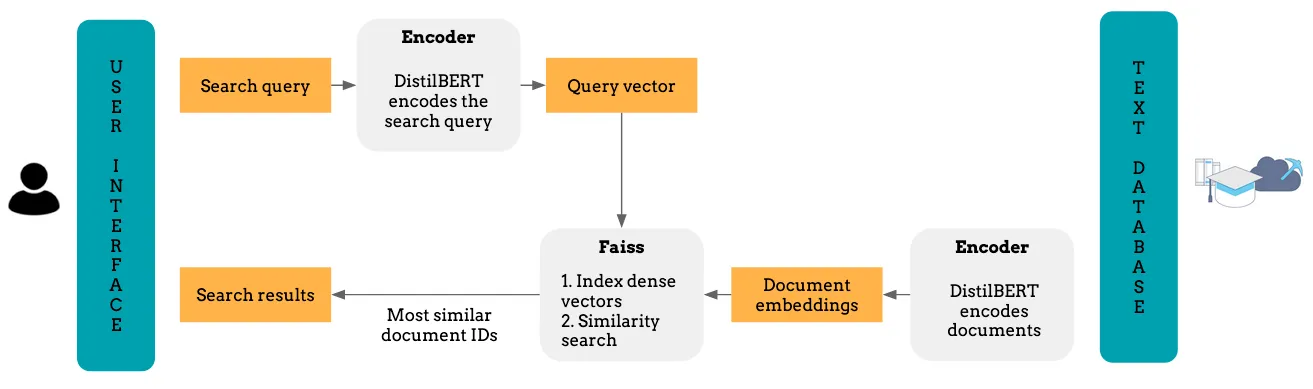

In [ ]:
from transformers import TextStreamer

# define a function to run the LLM with streaming support
def run(query, max_new_tokens=100):
  device = "cuda:0"
  inputs = tokenizer(query, return_tensors="pt").to(device)
  streamer = TextStreamer(tokenizer, skip_prompt=True)
  model.generate(**inputs, streamer=streamer, max_new_tokens=max_new_tokens)

### Ask the model what is QLoRA

It should not know it because this model is trained before QLoRA exists

In [ ]:
run("what is QLoRA", 50)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


?

QLoRA (Quantum Light Optics and Radiation Analysis) is a software package for the analysis of quantum light and radiation. It is designed to provide a comprehensive toolset for the simulation and analysis of quantum optical systems,


### Prepare libraries & Data

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install -q -U langchain pymupdf sentence_transformers faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.3 MB/s eta 0:00:00


Read QLoRA paper

In [ ]:
from langchain.document_loaders import PyMuPDFLoader
# QLoRA paper
url = "http://export.arxiv.org/pdf/2305.14314.pdf"
data = PyMuPDFLoader(url).load()

# divided by pages
print(len(data))

26


In [ ]:
data[0]

Document(page_content='QLORA: Efficient Finetuning of Quantized LLMs\nTim Dettmers∗\nArtidoro Pagnoni∗\nAri Holtzman\nLuke Zettlemoyer\nUniversity of Washington\n{dettmers,artidoro,ahai,lsz}@cs.washington.edu\nAbstract\nWe present QLORA, an efficient finetuning approach that reduces memory us-\nage enough to finetune a 65B parameter model on a single 48GB GPU while\npreserving full 16-bit finetuning task performance. QLORA backpropagates gradi-\nents through a frozen, 4-bit quantized pretrained language model into Low Rank\nAdapters (LoRA). Our best model family, which we name Guanaco, outperforms\nall previous openly released models on the Vicuna benchmark, reaching 99.3%\nof the performance level of ChatGPT while only requiring 24 hours of finetuning\non a single GPU. QLORA introduces a number of innovations to save memory\nwithout sacrificing performance: (a) 4-bit NormalFloat (NF4), a new data type that\nis information theoretically optimal for normally distributed weights (b) Doub

### Prepare embeddings

* Use same embedding model [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) for documents & queries
* Use [FAISS](https://github.com/facebookresearch/faiss) for vector search
  - An open-source library for similarity search, with support for various index types
  - e.g. LSH(local sensitive hash), a family of hashing algorithms that can map similar vectors to close hash values, which allows dividing the data into buckets
  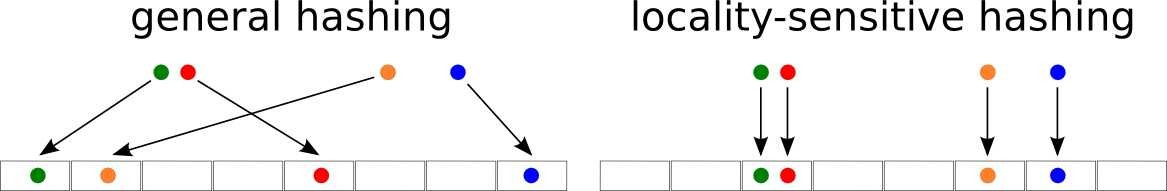

In [ ]:
from langchain.embeddings.base import Embeddings
from typing import List
from sentence_transformers import SentenceTransformer

class LocalHuggingFaceEmbeddings(Embeddings):
    def __init__(self, model_id):
        self.model = SentenceTransformer(model_id)

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        embeddings =self.model.encode(texts)
        return embeddings

    def embed_query(self, text: str) -> List[float]:
        embedding = self.model.encode(text)
        return list(map(float, embedding))

In [ ]:
from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders import UnstructuredMarkdownLoader
from langchain.embeddings.base import Embeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.vectorstores import FAISS
from typing import List
import time
import os

FAISS_INDEX_PATH="faiss_index"

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 300,
    chunk_overlap  = 20,
    length_function = len,
)

st = time.time()
print('Loading documents ...')


chunks = text_splitter.create_documents([doc.page_content for doc in data], metadatas=[doc.metadata for doc in data])
et = time.time() - st
print(f'Time taken: {et} seconds.')

embeddings = LocalHuggingFaceEmbeddings('all-MiniLM-L6-v2')
print(f'Loading chunks into vector store ...')
st = time.time()
db = FAISS.from_documents(chunks, embeddings)
db.save_local(FAISS_INDEX_PATH)
et = time.time() - st
print(f'Time taken: {et} seconds.')

Loading documents ...
Time taken: 0.042314767837524414 seconds.


Loading chunks into vector store ...
Time taken: 0.9710783958435059 seconds.


### Try sementic search

The same embedding model will create embedding from query, then found closest documents that related to the query.

In [ ]:
db.max_marginal_relevance_search('What is QLoRA')

[Document(page_content='type that is usually BFloat16. In practice, this means whenever a QLORA weight tensor is used, we\ndequantize the tensor to BFloat16, and then perform a matrix multiplication in 16-bit.\nWe now discuss the components of QLORA followed by a formal definition of QLORA.\n4-bit NormalFloat Quantization', metadata={'source': '/tmp/tmpeh8u4tkq/tmp.pdf', 'file_path': '/tmp/tmpeh8u4tkq/tmp.pdf', 'page': 3, 'total_pages': 26, 'format': 'PDF 1.5', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': 'LaTeX with hyperref', 'producer': 'pdfTeX-1.40.25', 'creationDate': 'D:20230524011032Z', 'modDate': 'D:20230524011032Z', 'trapped': ''}),
 Document(page_content='in the hands of large corporations that do not release models or source code for auditing.\nAll in all, we believe that QLORA will have a broadly positive impact making the finetuning of high\nquality LLMs much more widely and easily accessible.\nAcknowledgements', metadata={'source': '/tmp/tmpeh8u4tk

### Prompt engineering

In [ ]:
from peft.tuners import prompt_tuning
def answer(question, max_token=50):
  similar_docs = db.max_marginal_relevance_search(question)
  context = "\n".join(map(lambda d: d.page_content, similar_docs))
  prompt = f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.

Instruction:
You are a ChatBot to help providing the best answer based on provided context.
Use only information in the following paragraphs to answer the question at the end. Explain the answer with reference to these paragraphs. If you don't know, say that you do not know.

{context}

Question: {question}

Response:
"""
  print(prompt)

  run(prompt, max_token)


### Try ask again

Now with the context, the LLM will better answer the question

In [ ]:
answer("what is QLoRA", 100)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

Instruction:
You are a ChatBot to help providing the best answer based on provided context.
Use only information in the following paragraphs to answer the question at the end. Explain the answer with reference to these paragraphs. If you don't know, say that you do not know.

type that is usually BFloat16. In practice, this means whenever a QLORA weight tensor is used, we
dequantize the tensor to BFloat16, and then perform a matrix multiplication in 16-bit.
We now discuss the components of QLORA followed by a formal definition of QLORA.
4-bit NormalFloat Quantization
in the hands of large corporations that do not release models or source code for auditing.
All in all, we believe that QLORA will have a broadly positive impact making the finetuning of high
quality LLMs much more widely and easily accessible.
Acknowledgements
across different models (OPT [72], LLaMA [57], BLOOM [52],